In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import easyocr
import string
import re

# Flow

# Identifying text regions
1) subtract each frame from the one before to create a "motion" image
2) collapse to 1d vertically so we can identify y ranges of motion
3) run a text identifier on a single frame for each group of y ranges to see which matches DD MM, HH:MM

# Getting the unique individual frames
4) Run the same preprocessing on each frame 
5) Search the date area for a date
6) If unique, this frame is kept

# Recording the weight and storing data
7) For unique frames, record the weight
8) Process the datetimes and weights to make sure they fit expected format
9) Store final data in a dataframe


total frames are  600


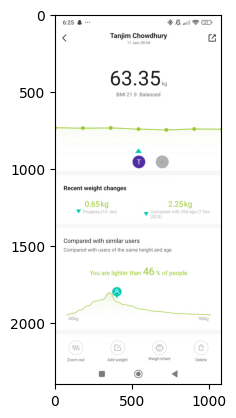

In [2]:
video_path = 'test_data/test.mp4'

cap = cv2.VideoCapture(video_path)

cap.set(cv2.CAP_PROP_POS_FRAMES, 1)

ret, frame = cap.read()

print("total frames are ", int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))

cap.release()

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.imshow(frame_rgb)
plt.show()


In [3]:
# Path to the video file
video_path = 'test_data/test.mp4'

# Open the video file
cap = cv2.VideoCapture(video_path)

# Get the total number of frames
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Initialize variables for accumulating differences
accumulated_diff = None
frame_count = 0

# Read the first frame
ret, prev_frame = cap.read()

# Check if the frame is read correctly
if not ret:
    print("Error reading the first frame")

while ret:
    # Read the next frame
    ret, current_frame = cap.read()
    
    if not ret:
        break
    
    # Convert frames to grayscale
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    current_gray = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
    
    # Compute the absolute difference between the current frame and the previous frame
    diff_frame = cv2.absdiff(current_gray, prev_gray)
    
    # Accumulate the difference
    if accumulated_diff is None:
        accumulated_diff = np.zeros_like(diff_frame, dtype=np.float32)
    
    accumulated_diff += diff_frame
    frame_count += 1
    
    # Set the current frame as the previous frame for the next iteration
    prev_frame = current_frame

# Release the video capture object
cap.release()

# Convert the average difference to uint8
motion_2d_arr = cv2.normalize(accumulated_diff, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)


In [4]:
# collapse to 1d array around the centre 50%
x_start = motion_2d_arr.shape[1] // 4 
x_end =  motion_2d_arr.shape[1] * 3 // 4
motion_2d_arr_middle = motion_2d_arr[:, x_start : x_end]
motion_1d_arr = np.mean(motion_2d_arr_middle, axis=1).astype(int)

# the most motion happens at the middle line
# we know the date is definitely above so lets filter to before then
# also we know the width of the filter line is about 100 pix maximum for 2400 pix video
motion_1d_arr_top = motion_1d_arr[:np.argmax(motion_1d_arr)- int(2400*100/len(motion_1d_arr))]

# binarize
motion_1d_arr_binary = (motion_1d_arr_top > 0).astype(int)

# get the start and end indices of each run
diff = np.diff(motion_1d_arr_binary)
start_indices = np.where(diff==1)[0] + 1
end_indices = np.where(diff==-1)[0]
run_indices = list(zip(start_indices, end_indices))

In [5]:
# now lets open up the middle frame of the video
cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, int(total_frames/2))
ret, frame = cap.read()
cap.release()

# intialise OCR
reader = easyocr.Reader(['en'])

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [6]:
# identify where the date and where the weight is written
date_found = False
date_run = []
weight_found = False
weight_run = []

remove_punctuation = str.maketrans('', '', string.punctuation)
date_pattern = r'^\d{1,2} [A-Za-z]{3}( \d{4})? \d{4}$'

for run in run_indices:
    cropped_frame = frame[run[0]-3:run[1]+6, x_start:x_end]
    gray_frame = cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2GRAY)
    text = reader.readtext(gray_frame)

    # if no text is found we move on
    if len(text) == 0:
        continue

    # text is a list of tuples. tuples have 3 parts

    # for the date it is DD Mmm (YYYY), HH:MM
    if not date_found:
        no_punc_text = text[0][1].translate(remove_punctuation)
        match = re.match(date_pattern, no_punc_text)
        if bool(match):
            # date run has been found
            date_found = True
            date_run = run
    
    # for the weight, the second tuple should have kg as the middle element
    if not weight_found:
        if len(text)<2:
            continue
        match = re.match(r"kg", text[1][1])
        if bool(match):
            # weight run has been found
            weight_found = True
            weight_run = run


In [8]:
# store date and weight info below
dates = []
weights = []

last_date = None
first_frame_done = False
prev_frame = []

differences = []
frames_checked = 0

# loop through each frame

cap = cv2.VideoCapture(video_path)

while True:
    ret, frame = cap.read()

    if not ret:
        break

    # crop frame to date portion
    cropped_frame = frame[date_run[0]-3:date_run[1]+6, x_start:x_end]
    gray_frame = cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2GRAY)


    if first_frame_done == False:
        # if its the first frame we move on
        prev_frame = gray_frame
        first_frame_done = True
        continue
    
    # lets see if the frame has changed
    difference = (gray_frame - prev_frame).sum()
    differences.append(difference)
    prev_frame = gray_frame
    
    # if the difference is less than 4,000 then we can assume the frame has remained the same
    if difference < 4_000:
        continue
    
    frames_checked +=1

    text = reader.readtext(gray_frame)
    
    # check if text detected
    if len(text)>0:

        # remove any punctuation
        no_punc_text = text[0][1].translate(remove_punctuation)

        # do we already have this date?
        if no_punc_text != last_date:
            dates.append(no_punc_text)
            last_date = no_punc_text
        else:
            continue

    # record the weight 
    weight_cropped = frame[weight_run[0]-3:weight_run[1]+6, x_start:x_end]
    gray_weight = cv2.cvtColor(weight_cropped, cv2.COLOR_BGR2GRAY)
    weight_text = reader.readtext(gray_weight)

    if len(weight_text)>0:
        weights.append(weight_text[0][1])
    else:
        weights.append(np.nan)

cap.release()
dates, frames_checked


(['11 Jan 0934',
  '10 Jan 0945',
  '9 Jan 0756',
  '8 Jan 0918',
  '7 Jan 1308',
  '6 Jan 1019',
  '5 Jan 0921',
  '4 Jan 1006',
  '3 Jan 0959',
  '2 Jan 0811',
  'Jan 1249',
  '31 Dec 20231246',
  '30 Dec 20231208',
  '29 Dec 20231139',
  '28 Dec 20230902',
  '28 Dec 2023 0902',
  '27 Dec 20231301',
  '26 Dec 20231156',
  '25 Dec 20231146',
  '24 Dec 20231140',
  '23 Dec 20231108',
  '22 Dec 20231129'],
 86)